In [1]:
import numpy as np
import pandas as pd

In [2]:
import dask.dataframe as dd
import dask.array as da
import dask.bag as db

In [3]:
index = pd.date_range("2021-09-01", periods=2400, freq="1h")
df = pd.DataFrame({"a": np.arange(2400), "b": list("abcaddbe" * 300)}, index=index)
ddf = dd.from_pandas(df, npartitions=10)

In [4]:
ddf

,a,b
npartitions=10,,
2021-09-01 00:00:00,int64,string
2021-09-11 00:00:00,...,...
...,...,...
2021-11-30 00:00:00,...,...
2021-12-09 23:00:00,...,...


In [12]:
ddf.divisions

(Timestamp('2021-09-01 00:00:00'),
 Timestamp('2021-09-11 00:00:00'),
 Timestamp('2021-09-21 00:00:00'),
 Timestamp('2021-10-01 00:00:00'),
 Timestamp('2021-10-11 00:00:00'),
 Timestamp('2021-10-21 00:00:00'),
 Timestamp('2021-10-31 00:00:00'),
 Timestamp('2021-11-10 00:00:00'),
 Timestamp('2021-11-20 00:00:00'),
 Timestamp('2021-11-30 00:00:00'),
 Timestamp('2021-12-09 23:00:00'))

In [14]:
ddf.partitions[0]

,a,b
npartitions=1,,
2021-09-01,int64,string
2021-09-11,...,...


In [65]:
data = np.arange(100_000).reshape(200, 500)
a = da.from_array(data, chunks=(100, 100))

In [66]:
a

dask.array<array, shape=(200, 500), dtype=int64, chunksize=(100, 100), chunktype=numpy.ndarray>

In [67]:
a.chunks

((100, 100), (100, 100, 100, 100, 100))

In [68]:
a.blocks[1, 3]

dask.array<blocks, shape=(100, 100), dtype=int64, chunksize=(100, 100), chunktype=numpy.ndarray>

In [69]:
a[50:150, :200]

dask.array<getitem, shape=(100, 200), dtype=int64, chunksize=(50, 100), chunktype=numpy.ndarray>

In [70]:
a[50:150, :200].compute()

array([[25000, 25001, 25002, ..., 25197, 25198, 25199],
       [25500, 25501, 25502, ..., 25697, 25698, 25699],
       [26000, 26001, 26002, ..., 26197, 26198, 26199],
       ...,
       [73500, 73501, 73502, ..., 73697, 73698, 73699],
       [74000, 74001, 74002, ..., 74197, 74198, 74199],
       [74500, 74501, 74502, ..., 74697, 74698, 74699]])

In [71]:
a.mean()

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [89]:
b = a.max(axis=0)

In [90]:
a.shape

(200, 500)

In [91]:
print(b)

dask.array<max-aggregate, shape=(500,), dtype=int64, chunksize=(100,), chunktype=numpy.ndarray>


In [93]:
b.dask

HighLevelGraph with 3 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x752d90654fd0>
 0. array-e81675423ad09a91da06e341b2c3771d
 1. chunk_max-04c1272469119d1897a7142b63c04960
 2. max-aggregate-b90e7a4cf6ba019824bb0cb043a677d0

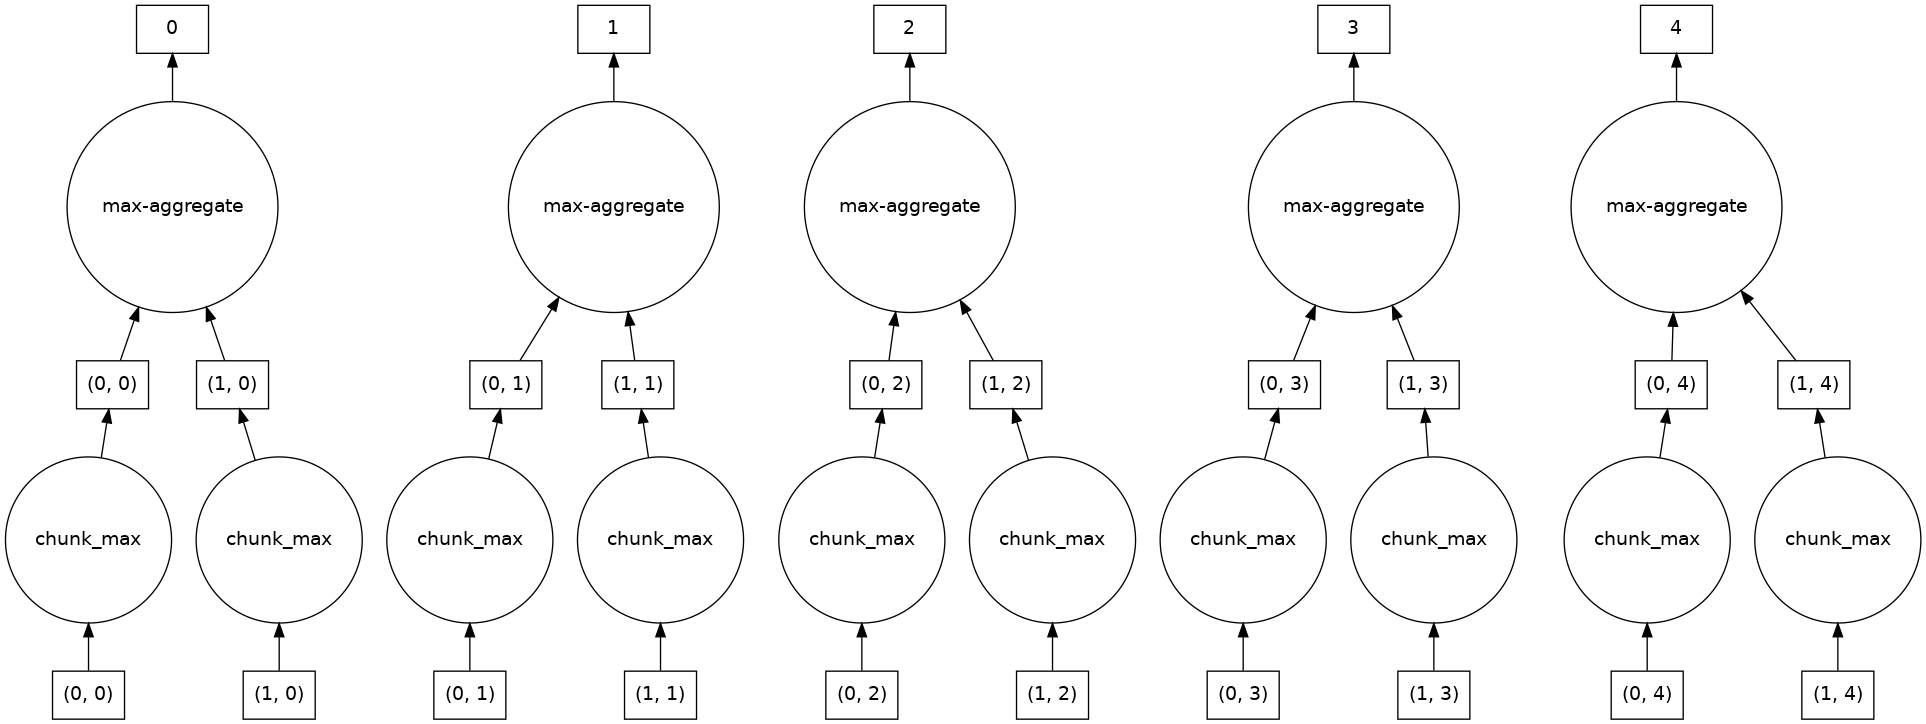

In [96]:
b.visualize()

In [95]:
b.dask

HighLevelGraph with 3 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x752d90654fd0>
 0. array-e81675423ad09a91da06e341b2c3771d
 1. chunk_max-04c1272469119d1897a7142b63c04960
 2. max-aggregate-b90e7a4cf6ba019824bb0cb043a677d0

In [53]:
a.npartitions

10

In [54]:
a.numblocks

(2, 5)

In [100]:
import dask

@dask.delayed
def inc(x):
   return x + 1

@dask.delayed
def add(x, y):
   return x + y

a = inc(1)       # no work has happened yet
b = inc(2)       # no work has happened yet
c = add(a, b)    # no work has happened yet

d = c.compute()  # This triggers all of the above computations

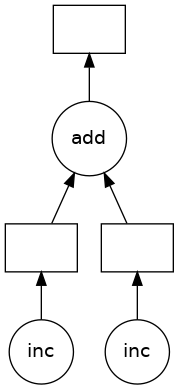

In [101]:
c.visualize()

In [109]:
from dask.distributed import Client

client = Client()

def inc(x):
   return x + 1

def add(x, y):
   return x + y

a = client.submit(inc, 1)     # work starts immediately
b = client.submit(inc, 2)     # work starts immediately
c = client.submit(add, a, b)  # work starts immediately

e = c.result()                # block until work finishes, then gather result

/home/pk/Documents/rtseg/.venv/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34631 instead
  warnings.warn(
2024-07-29 16:53:19,673 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/pk/Documents/rtseg/.venv/lib/python3.11/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/pk/Documents/rtseg/.venv/lib/python3.11/site-packages/distributed/worker.py", line 1251, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pk/Documents

In [107]:
c.visualize()

AttributeError: 'Future' object has no attribute 'visualize'

In [60]:
print(client)

<Client: 'tcp://127.0.0.1:36887' processes=3 threads=6, memory=94.21 GiB>


In [61]:
client.dashboard_link

'http://127.0.0.1:8787/status'

In [11]:
b = db.from_sequence([1, 2, 3, 4, 5, 6, 2, 1], npartitions=2)
b

dask.bag<from_sequence, npartitions=2>